# Attempt to use cpDistiller

In [8]:
import scanpy as sc
import anndata as ad
from cpDistiller import DataSet, labeled, cpDistiller_Model, scale_batch
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
adata_orig = ad.read_h5ad("/home/icb/tim.treis/projects/broad_integrate/2023_Arevalo_BatchCorrection/outputs/scenario_7/mad_int_featselect_all_methods.h5ad")
adata_orig

AnnData object with n_obs × n_vars = 25329 × 1018
    obs: 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_Batch', 'Metadata_PlateType', 'Metadata_PertType', 'Metadata_Row', 'Metadata_Column', 'Metadata_Microscope'
    obsm: 'combat', 'cpDistiller', 'cpDistiller_B', 'cpDistiller_S', 'cpDistiller_SBP', 'desc', 'fastMNN', 'gaushanvi', 'gaushvi', 'harmony', 'scanorama', 'scanorama_pca', 'scanvi', 'scpoli', 'scvi', 'seurat_cca', 'seurat_rpca', 'sphering', 'sysvi'

## Correct for Batch

In [12]:
adata_batch = adata_orig.copy()
adata_batch.obs = adata_batch.obs.rename(columns={
    "Metadata_Batch": "batch",
    "Metadata_Row": "row",
    "Metadata_Column": "col",
})

scale_batch(adata_batch)
sc.pp.scale(adata_batch)
dat = DataSet(adata_batch, batch_size=256, mod=1)
labeled(adata_batch, Mnn=5, Knn=10, technic_name_list=["batch", "row", "col"])
cpDistiller = cpDistiller_Model(
    dat,
    epochs=50, # tried 100 epochs, basically same numbers
    model_path='./ckpts/',
    reduction='mean',
    mo='Extractor'
) 

2025-01-29 01:02:12,938 - INFO - MNN pairs num: 1497436
2025-01-29 01:02:31,708 - INFO - KNN pairs num: 220835


In [13]:
cpDistiller.train()
cpDistiller.ema.apply()
result_batch, _ = cpDistiller.eval(dat.data)
cpDistiller.ema.restore()

2025-01-29 01:02:35,847 - INFO - GMVAE_DL(
  (pca_attention): PCAAttentionBlock(
    (attention): EfficientAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (conv1): Conv1d(1, 1, kernel_size=(1,), stride=(1,), bias=False)
      (sigmoid): Sigmoid()
    )
    (attetion_linear): Linear(in_features=144, out_features=32, bias=True)
    (attention_activation): ReLU()
    (output_linear): Linear(in_features=32, out_features=144, bias=True)
    (output_activation): ReLU()
  )
  (encode): GM_Encoder(
    (qy_x): Sequential(
      (0): Linear(in_features=1018, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (GumbelSoftmax): GumbelSoftmax(
      (logits): Linear(in_features=512, out_features=10, bias=True)
    )
    (qz_yx): Sequential(
      (0): Linear(in_features=1028, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)

In [14]:
batch_result_df = pd.DataFrame(result_batch)
batch_result_df.columns = [f"cpDistiller_{i}" for i in range(batch_result_df.shape[1])]
batch_result_df.index = adata_batch.obs.index
batch_result_df

,cpDistiller_0,cpDistiller_1,cpDistiller_2,cpDistiller_3,cpDistiller_4,cpDistiller_5,cpDistiller_6,cpDistiller_7,cpDistiller_8,cpDistiller_9,...,cpDistiller_40,cpDistiller_41,cpDistiller_42,cpDistiller_43,cpDistiller_44,cpDistiller_45,cpDistiller_46,cpDistiller_47,cpDistiller_48,cpDistiller_49
0,-2.743905,0.845909,-1.559889,-1.962976,1.953311,0.140060,0.204978,-1.033873,-1.622993,-3.533432,...,1.773317,0.513318,2.971371,-3.553456,0.427887,-1.694825,-1.206052,-0.968459,1.958164,1.725006
1,-2.205836,0.476962,2.042360,-2.083613,2.834198,-1.706657,0.252879,-0.153066,1.720765,-2.343599,...,1.143456,1.938647,0.272950,-2.671484,1.948266,-0.500293,-1.400004,2.187194,1.298781,3.035147
2,-3.034238,0.527190,-1.161110,-1.224152,2.241395,-3.537928,0.817547,2.789132,-1.638017,-2.132547,...,3.259613,1.883597,3.313526,0.854207,1.870576,-3.181919,-0.460677,0.164135,2.156445,1.879783
3,0.156336,1.336805,-0.155602,-2.646422,3.554170,-1.342643,0.191777,-3.024942,1.750252,-2.891446,...,2.672836,2.047284,0.308106,-0.777385,1.663999,-1.916537,-1.511974,3.849841,0.734576,3.059480
4,-1.301026,-1.296436,2.593945,-1.950644,-0.035753,-2.029128,1.236220,2.726671,-0.138025,-3.275542,...,0.874472,2.354130,6.144408,-1.863629,1.943327,-0.873289,-0.880056,-2.567700,1.923534,0.313014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25324,-2.305966,-3.189384,-2.800083,-1.756206,3.079751,-1.478496,0.691029,-0.700730,-1.358415,-0.785108,...,1.935241,1.818995,-0.461961,-1.892255,4.943128,-0.938541,-1.717595,-0.498500,3.550282,2.466403
25325,-1.666918,0.266162,0.795637,-0.131002,0.669616,-2.018192,2.527192,1.390451,0.319085,-2.231487,...,1.716266,1.531060,4.496863,-1.767697,0.678015,-0.701782,-0.989701,3.706640,-0.240316,1.762601
25326,-2.995983,0.168450,2.389104,-0.436946,0.989707,-4.933440,1.812746,1.191837,0.100657,-1.246096,...,2.138188,2.580291,1.547526,-4.497399,1.851358,-1.208730,-1.776898,2.818165,1.511119,2.001958
25327,-3.842553,3.218818,1.522773,-2.318273,2.470532,-3.064699,1.574940,0.778603,-1.354370,-0.806175,...,2.460626,2.043666,2.998619,-2.465334,1.590646,-1.435931,-0.653147,1.716186,2.389539,2.126770


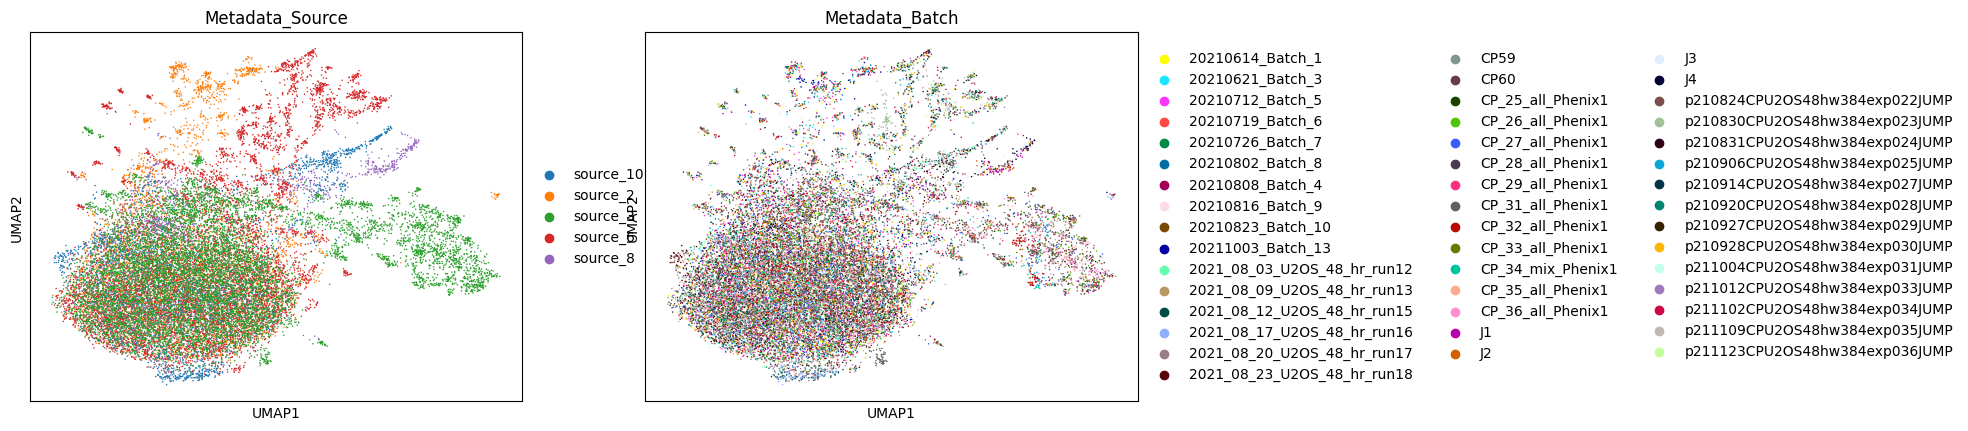

In [16]:
adata_batch_corrected = ad.AnnData(batch_result_df, obs=adata_orig.obs)
sc.pp.neighbors(adata_batch_corrected)
sc.tl.umap(adata_batch_corrected)
sc.pl.umap(adata_batch_corrected, color=["Metadata_Source", "Metadata_Batch"])

## Correct for Source

In [19]:
adata_source = adata_orig.copy()
adata_source.obs = adata_source.obs.rename(columns={
    "Metadata_Source": "batch",
    "Metadata_Row": "row",
    "Metadata_Column": "col",
})

scale_batch(adata_source)
sc.pp.scale(adata_source)
dat = DataSet(adata_source, batch_size=256, mod=1)
labeled(adata_source, Mnn=5, Knn=10, technic_name_list=["batch", "row", "col"])
cpDistiller = cpDistiller_Model(
    dat,
    epochs=50, # tried 100 epochs, basically same numbers
    model_path='./ckpts/',
    reduction='mean',
    mo='Extractor'
) 

2025-01-24 02:40:32,941 - INFO - MNN pairs num: 688580
2025-01-24 02:40:42,774 - INFO - KNN pairs num: 263665


In [20]:
cpDistiller.train()
cpDistiller.ema.apply()
source_result, _ = cpDistiller.eval(dat.data)
cpDistiller.ema.restore()

2025-01-24 02:41:48,143 - INFO - GMVAE_DL(
  (pca_attention): PCAAttentionBlock(
    (attention): EfficientAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (conv1): Conv1d(1, 1, kernel_size=(1,), stride=(1,), bias=False)
      (sigmoid): Sigmoid()
    )
    (attetion_linear): Linear(in_features=144, out_features=32, bias=True)
    (attention_activation): ReLU()
    (output_linear): Linear(in_features=32, out_features=144, bias=True)
    (output_activation): ReLU()
  )
  (encode): GM_Encoder(
    (qy_x): Sequential(
      (0): Linear(in_features=1018, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (GumbelSoftmax): GumbelSoftmax(
      (logits): Linear(in_features=512, out_features=10, bias=True)
    )
    (qz_yx): Sequential(
      (0): Linear(in_features=1028, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)

In [24]:
source_result_df = pd.DataFrame(source_result)
source_result_df.columns = [f"cpDistiller_{i}" for i in range(source_result_df.shape[1])]
source_result_df.index = adata_source.obs.index
source_result_df

,cpDistiller_0,cpDistiller_1,cpDistiller_2,cpDistiller_3,cpDistiller_4,cpDistiller_5,cpDistiller_6,cpDistiller_7,cpDistiller_8,cpDistiller_9,...,cpDistiller_40,cpDistiller_41,cpDistiller_42,cpDistiller_43,cpDistiller_44,cpDistiller_45,cpDistiller_46,cpDistiller_47,cpDistiller_48,cpDistiller_49
0,-1.385598,-4.700715,2.915752,0.622259,4.146342,-5.000999,0.678582,1.011764,1.683799,-2.011402,...,-0.237998,2.744430,1.000566,-3.946132,-0.431181,-1.680896,1.317230,1.891412,1.279697,1.848010
1,0.139119,-2.138427,1.814179,-1.274385,0.142397,-0.323401,2.558490,-1.238020,5.523767,-2.364149,...,0.256274,1.635319,-0.765474,0.066128,-1.833215,-2.624151,2.167061,1.048693,1.515095,1.653981
2,-2.154329,2.555989,0.784129,-1.206165,2.491330,-0.921110,0.545604,0.221103,0.347848,-1.266123,...,0.852170,2.197768,0.916499,0.359429,0.015692,-1.311123,-1.257434,0.692083,0.815471,0.489795
3,-1.301827,-1.449160,3.469365,-0.509374,0.604965,-0.240442,0.133340,-2.787967,3.913988,-2.220750,...,1.487415,2.123128,0.641690,-2.205496,0.054971,-1.627067,-2.105619,1.577800,1.858109,1.400659
4,-1.002682,-0.769027,0.552510,-3.082233,2.856773,-3.189781,0.476086,2.564314,3.508760,-1.680359,...,-0.150707,2.491451,1.234227,-0.634860,-2.320177,-2.119790,0.264560,2.330376,2.496942,2.805651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25324,-3.831380,-1.467328,-1.057823,-0.277835,5.907609,-3.623644,1.294760,1.186666,2.080862,-1.752198,...,0.678623,2.270887,-1.644854,-1.120033,-0.402379,-2.797025,-0.638792,1.446337,3.083448,1.685238
25325,-1.378809,3.691360,-0.393183,-1.397700,3.705987,-1.198000,1.481045,-0.031107,-2.292125,-1.234670,...,2.936782,0.610565,3.818873,-2.664040,-0.181761,-1.160118,-1.017532,-0.904643,2.058059,1.171644
25326,-1.618054,1.720482,-1.026638,-3.017819,-0.225376,-0.609862,1.986556,-0.771128,1.162431,-2.702935,...,0.833319,1.046142,0.341973,0.116066,1.136534,-1.184561,-0.042676,1.097192,0.750470,3.667048
25327,-1.680307,-3.117285,1.830022,-1.185672,0.474474,-0.985727,0.721464,-0.449901,-0.340167,-0.409458,...,0.449094,2.142107,0.420999,-0.837836,-0.612706,-1.887254,0.050212,1.805439,1.693615,2.059833


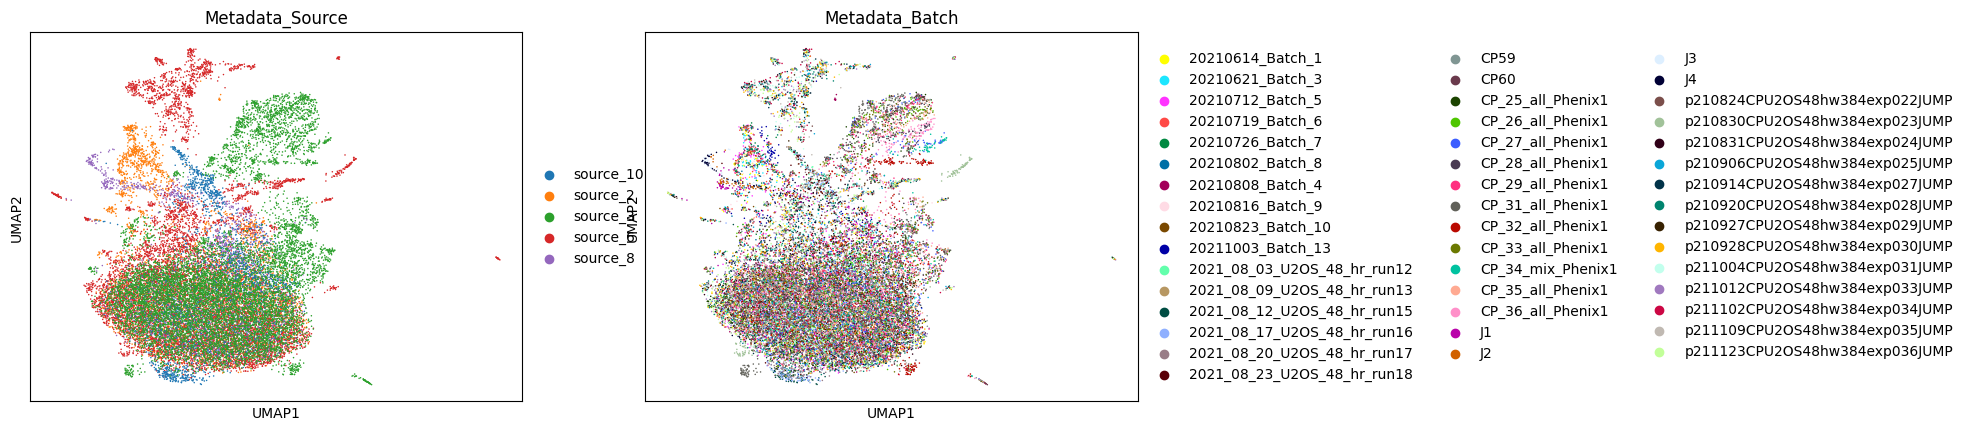

In [25]:
adata_source_corrected = ad.AnnData(source_result_df, obs=adata_orig.obs)
sc.pp.neighbors(adata_source_corrected)
sc.tl.umap(adata_source_corrected)
sc.pl.umap(adata_source_corrected, color=["Metadata_Source", "Metadata_Batch"])

## Correct for Source, Batch, Plate

In [26]:
adata_source_batch_plate = adata_orig.copy()
adata_source_batch_plate.obs = adata_source_batch_plate.obs.rename(columns={
    "Metadata_Source": "batch",
    "Metadata_Batch": "row",
    "Metadata_Plate": "col",
})

scale_batch(adata_source_batch_plate)
sc.pp.scale(adata_source_batch_plate)
dat = DataSet(adata_source_batch_plate, batch_size=256, mod=1)
labeled(adata_source_batch_plate, Mnn=5, Knn=10, technic_name_list=["batch", "row", "col"])
cpDistiller = cpDistiller_Model(
    dat,
    epochs=50, # tried 100 epochs, basically same numbers
    model_path='./ckpts/',
    reduction='mean',
    mo='Extractor'
) 

2025-01-24 03:03:03,277 - INFO - MNN pairs num: 1831918
2025-01-24 03:03:35,269 - INFO - KNN pairs num: 266464


In [27]:
cpDistiller.train()
cpDistiller.ema.apply()
source_result, _ = cpDistiller.eval(dat.data)
cpDistiller.ema.restore()

2025-01-24 03:04:52,389 - INFO - GMVAE_DL(
  (pca_attention): PCAAttentionBlock(
    (attention): EfficientAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (conv1): Conv1d(1, 1, kernel_size=(1,), stride=(1,), bias=False)
      (sigmoid): Sigmoid()
    )
    (attetion_linear): Linear(in_features=144, out_features=32, bias=True)
    (attention_activation): ReLU()
    (output_linear): Linear(in_features=32, out_features=144, bias=True)
    (output_activation): ReLU()
  )
  (encode): GM_Encoder(
    (qy_x): Sequential(
      (0): Linear(in_features=1018, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (GumbelSoftmax): GumbelSoftmax(
      (logits): Linear(in_features=512, out_features=10, bias=True)
    )
    (qz_yx): Sequential(
      (0): Linear(in_features=1028, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)

In [28]:
source_batch_plate_result_df = pd.DataFrame(source_result)
source_batch_plate_result_df.columns = [f"cpDistiller_{i}" for i in range(source_batch_plate_result_df.shape[1])]
source_batch_plate_result_df.index = adata_source.obs.index
source_batch_plate_result_df

,cpDistiller_0,cpDistiller_1,cpDistiller_2,cpDistiller_3,cpDistiller_4,cpDistiller_5,cpDistiller_6,cpDistiller_7,cpDistiller_8,cpDistiller_9,...,cpDistiller_40,cpDistiller_41,cpDistiller_42,cpDistiller_43,cpDistiller_44,cpDistiller_45,cpDistiller_46,cpDistiller_47,cpDistiller_48,cpDistiller_49
0,-3.695390,1.107548,-0.700770,-1.441343,0.485128,2.560196,-2.963863,-2.042217,3.646436,4.456021,...,3.845617,-2.226555,0.918325,-1.398586,-2.541493,-2.237203,-0.629992,0.039107,-2.256713,4.779116
1,3.448349,1.614721,2.032660,-1.353574,3.185266,1.641479,-2.712501,-3.444298,3.324904,0.822105,...,0.277600,1.968062,-1.137038,-1.785041,-1.779664,1.841792,-1.128909,0.886707,-2.914467,2.275524
2,1.318326,1.016253,0.936832,1.149127,1.243706,-0.772200,-1.933170,0.341712,1.233460,2.357763,...,2.317684,-3.422290,0.476345,-2.737334,-0.579114,-1.380816,0.074886,1.278939,-0.990934,-2.389923
3,-0.996119,1.436298,-1.924659,0.038926,4.103750,0.757909,-3.178613,-6.393556,1.870700,-0.307514,...,1.013967,2.584359,0.104594,-2.293457,-2.555465,2.950294,-1.637286,1.113966,-3.551487,1.443830
4,3.575993,0.937595,4.477711,-0.747917,-0.067973,1.494345,-1.718146,-1.140295,1.650694,4.199166,...,1.015635,-3.574511,1.653542,-0.886886,-0.494532,-1.009477,-0.483621,0.967751,-1.915910,-2.447508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25324,-0.880139,0.431321,1.869450,-0.376146,1.951229,-1.450041,-2.035403,-0.617995,1.558530,2.207319,...,0.238943,-1.335029,-0.109975,-2.497596,0.753684,-1.712112,-1.135296,2.311352,-1.141338,0.104302
25325,4.200727,0.968313,2.300101,0.709752,0.651022,-0.647049,-0.745132,-0.831310,3.443834,-0.533409,...,2.723057,-4.813004,1.422067,-1.914454,-1.996571,-0.293307,-1.208788,2.343986,-3.461449,0.365543
25326,3.924150,1.584646,1.021557,0.975730,-0.935168,-1.818267,-1.700547,-1.592057,2.922479,1.827346,...,0.373240,1.238268,0.805235,-1.320098,-1.487878,1.272818,-1.753592,0.758068,-2.406615,-2.346518
25327,-0.627565,1.670732,0.854449,-0.020393,3.352702,0.699947,-1.843687,-4.176970,2.876921,1.552217,...,2.544003,-1.524035,-0.709828,-2.937328,-1.007357,0.676159,-0.053695,1.251434,-1.992859,2.608984


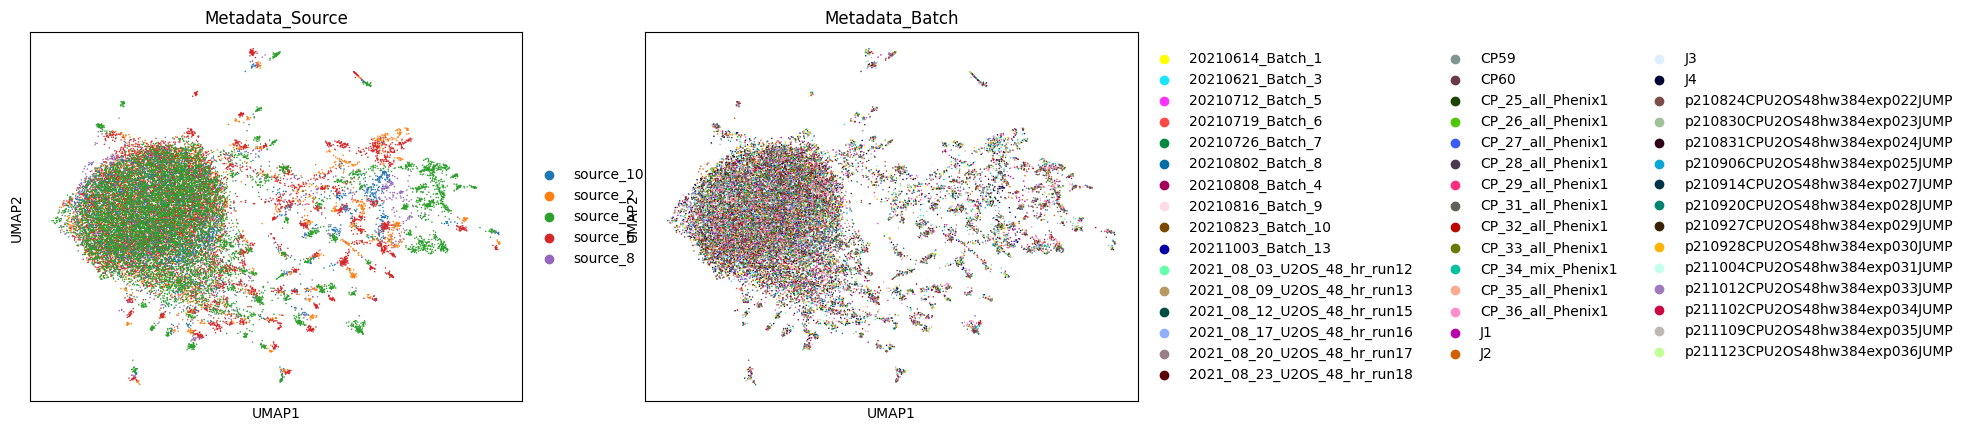

In [29]:
adata_source_batch_plate_corrected = ad.AnnData(source_batch_plate_result_df, obs=adata_orig.obs)
sc.pp.neighbors(adata_source_batch_plate_corrected)
sc.tl.umap(adata_source_batch_plate_corrected)
sc.pl.umap(adata_source_batch_plate_corrected, color=["Metadata_Source", "Metadata_Batch"])

## Correct for Source, Batch, Plate, Row, Col

In [ ]:
adata_sbprc = adata_orig.copy()
adata_sbprc.obs = adata_sbprc.obs.rename(columns={
    "Metadata_Source": "source",
    "Metadata_Batch": "batch",
    "Metadata_Plate": "plate",
    "Metadata_Row": "row",
    "Metadata_Column": "col",
})

scale_batch(adata_sbprc)
sc.pp.scale(adata_sbprc)
dat = DataSet(adata_sbprc, batch_size=256, mod=1)
labeled(adata_sbprc, Mnn=5, Knn=10, technic_name_list=["source", "batch", "plate", "row", "col"])
cpDistiller = cpDistiller_Model(
    dat,
    epochs=50, # tried 100 epochs, basically same numbers
    model_path='./ckpts/',
    reduction='mean',
    mo='Extractor'
) 

In [ ]:
cpDistiller.train()
cpDistiller.ema.apply()
result_sbprc, _ = cpDistiller.eval(dat.data)
cpDistiller.ema.restore()

In [ ]:
sbprc_result_df = pd.DataFrame(result_sbprc)
sbprc_result_df.columns = [f"cpDistiller_{i}" for i in range(sbprc_result_df.shape[1])]
sbprc_result_df.index = adata_sbprc.obs.index
sbprc_result_df

In [ ]:
adata_sbprc_corrected = ad.AnnData(sbprc_result_df, obs=adata_orig.obs)
sc.pp.neighbors(adata_sbprc_corrected)
sc.tl.umap(adata_sbprc_corrected)
sc.pl.umap(adata_sbprc_corrected, color=["Metadata_Source", "Metadata_Batch"])

### Do we use more than 3 covariates?

We only have 3 classifier heads, acting on the `batch`, `row` and `col` columns. What if we give the model more?

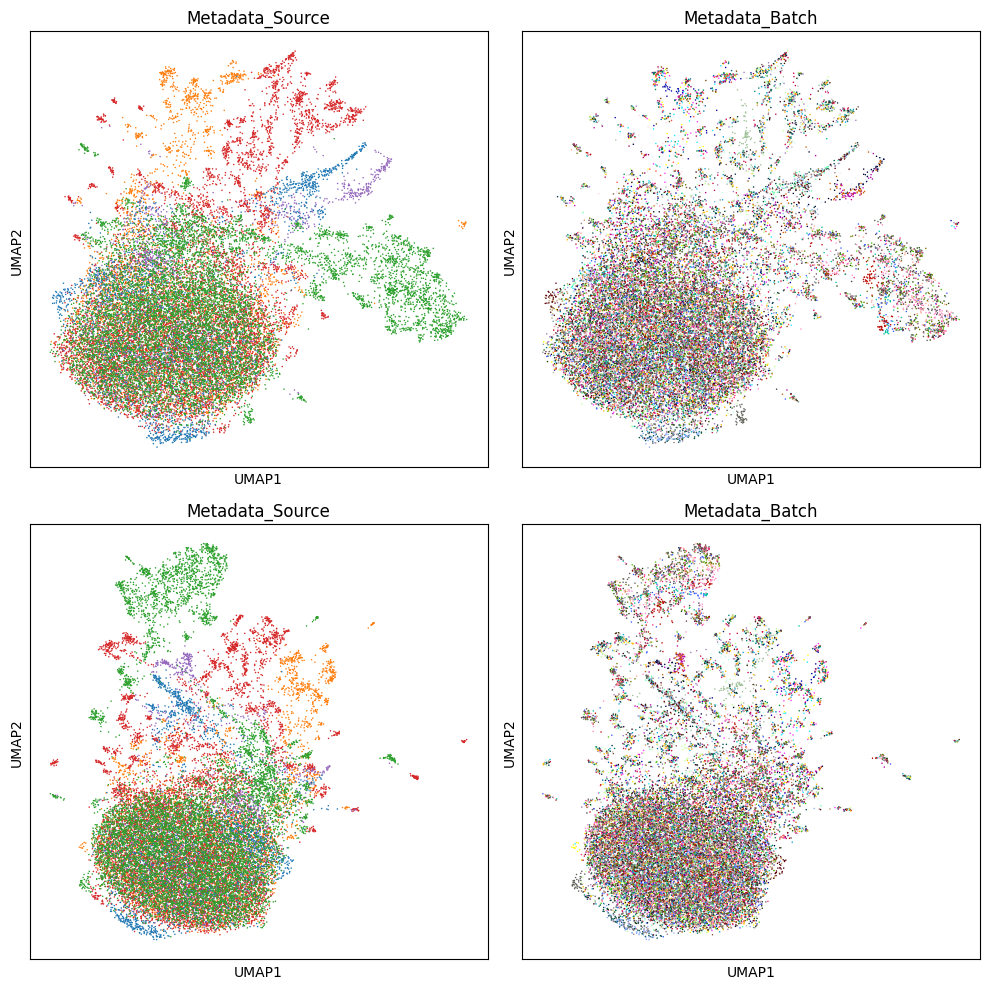

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sc.pl.umap(adata_batch_corrected, color=["Metadata_Source"], ax=axs[0, 0], show=False, legend_loc=None)
sc.pl.umap(adata_batch_corrected, color=["Metadata_Batch"], ax=axs[0, 1], show=False, legend_loc=None)
sc.pl.umap(adata_sbprc_corrected, color=["Metadata_Source",], ax=axs[1, 0], show=False, legend_loc=None)
sc.pl.umap(adata_sbprc_corrected, color=["Metadata_Batch"], ax=axs[1, 1], show=False, legend_loc=None)
fig.tight_layout()


## Optionally write to anndata for the benchmark

In [35]:
adata_orig.obsm["cpDistiller_B"] = batch_result_df
adata_orig.obsm["cpDistiller_S"] = source_result_df
adata_orig.obsm["cpDistiller_SBP"] = source_batch_plate_result_df
adata_orig

AnnData object with n_obs × n_vars = 25329 × 1018
    obs: 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_Batch', 'Metadata_PlateType', 'Metadata_PertType', 'Metadata_Row', 'Metadata_Column', 'Metadata_Microscope'
    obsm: 'combat', 'cpDistiller', 'desc', 'fastMNN', 'gaushanvi', 'gaushvi', 'harmony', 'scanorama', 'scanorama_pca', 'scanvi', 'scpoli', 'scvi', 'seurat_cca', 'seurat_rpca', 'sphering', 'sysvi', 'cpDistiller_B', 'cpDistiller_S', 'cpDistiller_SBP'

In [36]:
adata_orig.write_h5ad("/home/icb/tim.treis/projects/broad_integrate/2023_Arevalo_BatchCorrection/outputs/scenario_7/mad_int_featselect_all_methods.h5ad")